# Using pre trained YOLO model as a landmark classifier  

As we mentioned in the test.ipynb notebook (in the data directory), the test set we use is full of out of domain images. We would like to discard as many of them as possible. In order to do that we will use an object detector and further processing to create our own landmark classifier. 

### YOLO

We will use [YOLO](https://pjreddie.com/darknet/yolo/) (You Only Look Once) pre trained model as an object detctor. YOLO is a state of the art object detctor that achived great results on various data sets. We used [darknet](https://github.com/AlexeyAB/darknet) implemntation which allow to use pre-trained models easily. 

After cloning the darknet repo, we changed the Makefile in order it to use the GPU and preform faster (as described in the [readme]("https://github.com/AlexeyAB/darknet/blob/master/README.md") file). 

### Open Images Dataset

We chose to use the YOLOv3 that was pre trained on the [Open Images Dataset]("https://storage.googleapis.com/openimages/web/index.html"). Open Images dataset is a big, diverse data set with ~9M images annotated with image-level labels, object bounding boxes, object segmentation masks, visual relationships, and localized narratives. We used it's detection part that contain 15,851,536 boxes on 600 categories. The bounding box annotation made by people and not by computers and therefore are higly accurate.  

Out of the 600 categories we chose 5 categroies that could indicate that the image contain a landmark: Tower, Fountain, Skyscraper, Building and Castle.  

Another 8 categories could inidicate that the image may contain a landmark Bronze sculpture, Sculpture, Lighthouse, House, Tree, Palm tree, Watercraft, Hiking equipment. 

All the other classes can indicate that it is not a landmark. 

#### Examples: 

##### Landmarks: 

<img src="example_images/openimages_landmark_1.png" alt="Drawing" style="width: 400px;"/>
<img src="example_images/openimages_landmark_2.png" alt="Drawing" style="width: 400px;"/>

##### Maybe landmarks: 

<img src="example_images/openimages_maybe_landmark_1.png" alt="Drawing" style="width: 400px;"/>
<img src="example_images/openimages_maybe_landmark_2.png" alt="Drawing" style="width: 400px;"/>

##### Non-landmarks: 

<img src="example_images/openimages_non_landmark_1.png" alt="Drawing" style="width: 400px;"/>
<img src="example_images/openimages_non_landmark_2.png" alt="Drawing" style="width: 400px;"/>

#### Obejct detection results

We passed all the test set images inside the yolo-darknet implementation. The network produced a json file as a result. In this file each image is connected to its filename and the objects that detected in it. For each detected object there will be the corresponding class_id, name and the realtive coordinates, 

Some examples of the network result (on test set images) as images with bounding box: 

<img src="example_images/predictions1.jpg" alt="Drawing" style="width: 400px;"/>
<img src="example_images/predictions2.jpg" alt="Drawing" style="width: 400px;"/>
<img src="example_images/predictions3.jpg" alt="Drawing" style="width: 400px;"/>
<img src="example_images/predictions9.jpg" alt="Drawing" style="width: 400px;"/>

The results may not be perfect but they are good and the best that we can achive with that method.  

### COCO Dataset

In addition to YOLOv3 that was pre traine on Open Images Dataset, we also used YOLOv4 that was pre trained on the [COCO Dataset]("https://cocodataset.org/#home"). In the COCO Dataset there are no classes that we can label as landmark, therefore we'll use those detection to discard more out of domain images from our test set.  

#### Obejct detection results

Some examples of the network (that was pre-trained on COCO Dataset) result (on test set images) as images with bounding box: 

<img src="example_images/predictions_v4_1.jpg" alt="Drawing" style="width: 400px;"/>
<img src="example_images/predictions_v4_2.jpg" alt="Drawing" style="width: 400px;"/>
<img src="example_images/predictions_v4_3.jpg" alt="Drawing" style="width: 400px;"/>

As we can see from the results, the network can detect quite well objects in the scene but cannot detect any kind of landmark. 
Therefore, as we mentioned before, we'll use the results from this network to discard more images. 

We will further process the results file in oreder to clean the test set as much as possible. 

### Further processing

We will further process the results file in oreder to clean the test set as much as possible.

In [1]:
# imports for code 
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import re 

In [2]:
def pars_results(path):
    """
    Load the results file from the yolo v3 object detector and pars thh results file so
    every image will be connected to its filename and objects that detected in it.
    for each object that was detected there will be the corresponding class name, confidence level 
    and size (realtive to the image)  
    Param:
        path (string): The path to the results file 
    Return: 
        data (list): A list of dictionaries. Each element is a dictionary of an image after parsing.  
    """
    f = open(path)  
    data = json.load(f) 
 
    for i in range(len(data)): 
        file_name = re.search('[a-z & 0-9]{16}', data[i]['filename']).group(0)
        data[i]['filename'] = file_name
        if len(data[i]['objects']) != 0: 
            for j in range(len(data[i]['objects'])): 
                data[i]['objects'][j].pop('class_id', None)
                new_key1 = "class_name"
                old_key1 = "name"
                data[i]['objects'][j][new_key1] = data[i]['objects'][j].pop(old_key1)
                relative_size = data[i]['objects'][j]['relative_coordinates']['width'] *\
                                data[i]['objects'][j]['relative_coordinates']['height']
                data[i]['objects'][j].pop('relative_coordinates', None)
                data[i]['objects'][j]['realtive_size'] = relative_size
                new_key2 = "confidence_val"
                old_key2 = "confidence"
                data[i]['objects'][j][new_key2] = data[i]['objects'][j].pop(old_key2)                
    return data     

In [3]:
def processing_results(data):
    """
    Check if the objects that detcted in the test set images can be landmarks 
    Param:
        data (list): The parsed data 
    Return: 
        keep_df (DataFrame): A dataframe of the images that were labeled as landmarks 
        throw_df (DataFrame): A dataframe of the images that were labeled as non-landmarks 
    """
    
    # list of Open Images Dataset classes that we chose as "landmark" or "maybe_landmark"
    landmark = ['Tower', 'Fountain', 'Skyscraper', 'Building', 'Castle']
    maybe_landmark_1 = ['Bronze sculpture', 'Sculpture', 'Lighthouse', 'House']
    maybe_landmark_2 = ['Tree', 'Palm tree', 'Watercraft', 'Hiking equipment']
    
    keep = []
    throw = []
    for i in range(len(data)): 
        if len(data[i]['objects']) != 0: 
            for j in range(len(data[i]['objects'])): 
                # if any of the dtected objects can be defined as one of the landmark list we'll keep it   
                if data[i]['objects'][j]['class_name'] in landmark: 
                    keep.append(data[i])
                # if any of the detected objects can be defined as one of the maybe_landmark lists we will check its 
                # confidence value and realtive size.
                # for classes in maybe_landmarks_1 list we'll use large threshold,
                # because those classes are of big objects.
                # for classes in maybe_landmarks_2 list we'll use small threshold,
                # because those classes are of small objects.  
                elif data[i]['objects'][j]['class_name'] in maybe_landmark_1:
                    if data[i]['objects'][j]['confidence_val'] > 0.5 and data[i]['objects'][j]['realtive_size'] > 0.6:
                        keep.append(data[i])
                elif data[i]['objects'][j]['class_name'] in maybe_landmark_2:
                    if data[i]['objects'][j]['confidence_val'] > 0.5 and data[i]['objects'][j]['realtive_size'] < 0.2:
                        keep.append(data[i])
                # if the objects detected cannot be defined as landmark or maybe_landmark we will check its confidence value 
                # and its realtive size (to make sure its the major part of the image) to make sure we want to throw it as 
                # this image is not a landmark. 
                else: 
                    if data[i]['objects'][j]['confidence_val'] > 0.25 and data[i]['objects'][j]['realtive_size'] > 0.4: 
                        throw.append(data[i])
                        
    # remove duplicates rows
    keep_df_tmp = pd.DataFrame(keep)
    keep_df = keep_df_tmp.drop_duplicates(subset=['frame_id'])
    keep_df = keep_df.reset_index()
    keep_df = keep_df.drop('index', axis=1)
    
    throw_df_tmp = pd.DataFrame(throw)
    throw_df = throw_df_tmp.drop_duplicates(subset=['frame_id'])
    throw_df = throw_df.reset_index()
    throw_df = throw_df.drop('index', axis=1)

    # remove from "throw" rows that are also in "keep"
    if (keep_df.empty): # in case we use YOLOv4 data "keep" is empty
        return keep_df, throw_df 
    else: 
        keep_series = keep_df['frame_id']
        throw_df = throw_df[~throw_df["frame_id"].isin(keep_series)]
        throw_df = throw_df.reset_index()
        throw_df = throw_df.drop('index', axis=1)

    return keep_df, throw_df 

#### Using YOLOv3 object detection on all the available test set images 

In [4]:
path = 'result_yolov3_openimages.json'
data_v3_openimages = pars_results(path)
keep_v3_openimage, throw_v3_openimages = processing_results(data_v3_openimages) 

# save the keep_v3_openimage to dir
keep_v3_openimage.to_csv('C:/Users/Matan/Desktop/ProjectB/landmark_classifier/landmarks_csv_files/keep_v3_openimage.csv'\
                         , index = False) 
print("Using YOLO object detection and post processing, our object detector found {} images that can be labeled as"
      " landmark and {} images that can be labeled as non-landmark."\
      .format(keep_v3_openimage.shape[0], throw_v3_openimages.shape[0]))

throw_series = throw_v3_openimages['filename'] # all the images in throw_v3_openimages 

# load test set and remove from it all the images that were labled as non-landmark and therfore are in "throw_v3_openimages"
test_url = "https://raw.githubusercontent.com/matankleiner/ProjectB/master/data/test/test.csv"
test_df = pd.read_csv(test_url) 
clean_test_df = test_df[~test_df["id"].isin(throw_series)]
clean_test_df = clean_test_df.reset_index()
clean_test_df = clean_test_df.drop('index', axis=1)
# save the clean_test_v3 csv to dir
clean_test_df.to_csv('C:/Users/Matan/Desktop/projectB/data/test/clean_test_v3.csv', index = False) 
print("\nThe original size of the test set is {}. After removing from it all the images that where labled as non-landmark"
      "its size is {}.".format(test_df.shape[0], clean_test_df.shape[0]))

# load the test set without out of domain images
test_no_out_of_domain_url =\
            "https://raw.githubusercontent.com/matankleiner/ProjectB/master/data/test/test_no_out_of_domain.csv"
test_no_out_of_domain_df = pd.read_csv(test_no_out_of_domain_url) 
clean_test_no_out_of_domain_df = test_no_out_of_domain_df[~test_no_out_of_domain_df["id"].isin(throw_series)]
clean_test_no_out_of_domain_df = clean_test_no_out_of_domain_df.reset_index()
clean_test_no_out_of_domain_df = clean_test_no_out_of_domain_df.drop('index', axis=1)
print("\nThe original size of the test set without out of domain images is {}. "
      "After removing from it all the images that where    labled as non-landmark its size is {}. "
      "That mean we misclassify {} images.".format(test_no_out_of_domain_df.shape[0], \
      clean_test_no_out_of_domain_df.shape[0], \
      test_no_out_of_domain_df.shape[0] - clean_test_no_out_of_domain_df.shape[0]))

Using YOLO object detection and post processing, our object detector found 12659 images that can be labeled as landmark and 39824 images that can be labeled as non-landmark.

The original size of the test set is 117227. After removing from it all the images that where labled as non-landmarkits size is 77440.

The original size of the test set without out of domain images is 1622. After removing from it all the images that where    labled as non-landmark its size is 1579. That mean we misclassify 43 images.


#### Combine it with YOLOv4 object detection on all the available test set images 

In [5]:
path_1 = 'result_yolov4.json'
data_v4 = pars_results(path_1)
_, throw_v4 = processing_results(data_v4) # using YOLOv4 there are no images to "keep"  

In [6]:
# remove from throw_v4 rows that are also in keep_v3_openimage
keep_series = keep_v3_openimage['frame_id']
throw_v4 = throw_v4[~throw_v4["frame_id"].isin(keep_series)]
throw_v4 = throw_v4.reset_index()
throw_v4 = throw_v4.drop('index', axis=1)

# combine throw_v4 and throw_v3_openimages to create throw_all dataframe 
throw_v3_v4 = pd.concat([throw_v3_openimages, throw_v4])
throw_v3_v4 = throw_v3_v4.drop_duplicates(subset=['frame_id'])
throw_v3_v4 = throw_v3_v4.reset_index()
throw_v3_v4 = throw_v3_v4.drop('index', axis=1)

print("Using both YOLOv3 on Open Images Dataset and YOLOv4 on COCO dataset"
      " we labeld {} iamges as non landmark.".format(throw_v3_v4.shape[0]))

throw_series_1 = throw_v3_v4['filename'] # all the images in throw_v3_v4 

# load test set and remove from it all the images that were labled as non-landmark and therfore
# are in "throw_v3_v4"
test_url = "https://raw.githubusercontent.com/matankleiner/ProjectB/master/data/test/test.csv"
test_df = pd.read_csv(test_url) 
clean_test_v3_v4 = test_df[~test_df["id"].isin(throw_series_1)]
clean_test_v3_v4 = clean_test_v3_v4.reset_index()
#clean_test_v3_v4 = clean_test_v3_v4.drop('index', axis=1)
# save the clean_test_v3_v4 csv to dir
clean_test_v3_v4.to_csv('C:/Users/Matan/Desktop/projectB/data/test/clean_test_v3_v4.csv', index = False) 
print("\nThe original size of the test set is {}. After removing from it all the images that where labled as non-landmark"
      "its size is {}.".format(test_df.shape[0], clean_test_v3_v4.shape[0]))

# load the test set without out of domain images
test_no_out_of_domain_url =\
            "https://raw.githubusercontent.com/matankleiner/ProjectB/master/data/test/test_no_out_of_domain.csv"
test_no_out_of_domain_df = pd.read_csv(test_no_out_of_domain_url) 
clean_test_no_out_of_domain_v3_v4 = test_no_out_of_domain_df[~test_no_out_of_domain_df["id"].isin(throw_series_1)]
clean_test_no_out_of_domain_v3_v4 = clean_test_no_out_of_domain_v3_v4.reset_index()
clean_test_no_out_of_domain_v3_v4 = clean_test_no_out_of_domain_v3_v4.drop('index', axis=1)
print("\nThe original size of the test set without out of domain images is {}. "
      "After removing from it all the images that where    labled as non-landmark its size is {}. "
      "That mean we misclassify {} images.".format(test_no_out_of_domain_df.shape[0], \
      clean_test_no_out_of_domain_v3_v4.shape[0], \
      test_no_out_of_domain_df.shape[0] - clean_test_no_out_of_domain_v3_v4.shape[0]))

Using both YOLOv3 on Open Images Dataset and YOLOv4 on COCO dataset we labeld 48039 iamges as non landmark.

The original size of the test set is 117227. After removing from it all the images that where labled as non-landmarkits size is 69240.

The original size of the test set without out of domain images is 1622. After removing from it all the images that where    labled as non-landmark its size is 1554. That mean we misclassify 68 images.


In [7]:
thresh = [(0.3, 0.6), (0.3, 0.5), (0.3, 0.4), (0.25, 0.4), (0.25, 0.45), (0.25, 0.5), (0.1, 0.1), (0.01, 0.01),\
          (0.8, 0.5), (0.9, 0.9), (0.2, 0.3), (0.6, 0.7)]
landmarks = [28, 38, 59, 68, 57, 44, 286, 524, 9, 0, 105, 7]
images = [31317, 37545, 45357, 47987, 43713, 39742, 78601, 91631, 21969, 8449, 57795, 19611]

### Summary

We tried different threshold and got the following results (for both YOLOv3 and YOLOv4). 

We'll use Precision-Recall to check the differnce success of each threshold. 

Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p)$.

$P = \frac{T_p}{T_p+F_p}$

The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).

$R = \frac{T_p}{T_p+F_n}$

The recall is intuitively the ability of the classifier to find all the positive samples. 

In our case:

$T_p = $ Total # of Landmarks - Discarded Landmarks

$T_n = $ Discarder Images - Discarded Landmarks

$F_p = $ Total # of Images - Discarder Images - Total # of Landmarks + Discarded Landmarks 

$F_n = $ Discarded Landmarks

We'll also use $F1$ which is the harmonic mean of precision and recall: 

$F1 = 2\cdot\frac{P\cdot R}{P+R}$

| confidence_val, realtive_size |  Discarded Images | Discarded Landmarks | Precision (%) | Recall(%) | F1 |
| :---: | :---: | :---: | :---: | :---: | :---: |   
| 0.9, 0.9 | 8449| 0 | 1.49 | 100 | 0.029 |
| 0.8, 0.5 | 21969| 9 | 1.69 | 99.44 | 0.033 |
| 0.6, 0.7 | 19611| 7 | 1.65 | 99.56 | 0.032 |
| 0.3, 0.6 | 31317 | 28 | 1.85 | 98.27 | 0.036 |
| 0.3, 0.5 | 37545 | 38 | 1.98 | 97.65 | 0.038 |
| 0.3, 0.4 | 45357 | 59 | 2.17 | 96.36 | 0.042 |
| 0.25, 0.4 | 47987 | 68 | 2.24 | 95.8 | 0.043 |
| 0.25, 0.45 | 43713 | 57 | 2.13 | 96.48 | 0.041 |
| 0.25, 0.5 | 39742| 44 | 2.03 | 97.28 | 0.039 |
| 0.2, 0.3 | 57795| 105 | 2.55 | 93.52 | 0.049 |
| 0.1, 0.1 | 78601| 286 | 3.45 | 82.36 | 0.066 |
| 0.01, 0.01 | 91631| 524 | 4.28 | 67.69 | 0.08 |

In [8]:
def PR(discarded_landmarks, discarded_images, NImages=117227, Nlandmarks=1622): 
    Tp = Nlandmarks - discarded_landmarks
    Fp = NImages - discarded_images - Nlandmarks + discarded_landmarks
    Fn = discarded_landmarks
    R = Tp/(Tp+Fn)
    P = Tp/(Tp+Fp)
    F1 = 2 * (P*R) / (P+R)
    return P*100, R*100, F1

for i in range(len(images)): 
    print(f"For the thershold {thresh[i]}, (P,R) is: {PR(landmarks[i], images[i])[0:2]} and F1" 
          f" is {PR(landmarks[i],images[i])[2]}")

For the thershold (0.3, 0.6), (P,R) is: (1.8554301012687697, 98.27373612823675) and F1 is 0.03642096604670292
For the thershold (0.3, 0.5), (P,R) is: (1.987901910092618, 97.65721331689272) and F1 is 0.038964872576994984
For the thershold (0.3, 0.4), (P,R) is: (2.1747599833031863, 96.36251541307028) and F1 is 0.042535241931094536
For the thershold (0.25, 0.4), (P,R) is: (2.244367417677643, 95.80764488286067) and F1 is 0.0438598967006294
For the thershold (0.25, 0.45), (P,R) is: (2.128846206164812, 96.48581997533908) and F1 is 0.04165779386712096
For the thershold (0.25, 0.5), (P,R) is: (2.03652319803833, 97.28729963008631) and F1 is 0.03989533163942508
For the thershold (0.1, 0.1), (P,R) is: (3.458810127893129, 82.36744759556103) and F1 is 0.06638839196978731
For the thershold (0.01, 0.01), (P,R) is: (4.289732770745429, 67.69420468557337) and F1 is 0.08068190168270997
For the thershold (0.8, 0.5), (P,R) is: (1.6932961011148668, 99.44512946979039) and F1 is 0.03329892650701899
For the th

In order to better understand the results of our classifier we'll use ROC-curve. To plot the ROC-curve we'll need to define True Positive Rate ($TPR$) and False Positive Rate ($FPR$) 

$TPR = \frac{T_p}{T_p+F_n}$

True Positive Rate measures the proportion of positives that are correctly identified. 

$FPR = \frac{F_p}{F_p+T_n}$

False Positive Rate is the ratio between the number of negative events wrongly categorized as positive and the total number of actual negative events. 

In [9]:
def rate(discarded_landmarks, discarded_images, NImages=117227, Nlandmarks=1622): 
    Tp = Nlandmarks - discarded_landmarks
    Tn = discarded_images - discarded_landmarks
    Fp = NImages - discarded_images - Nlandmarks + discarded_landmarks
    Fn = discarded_landmarks
    TPR = Tp/(Tp+Fn)
    FPR = Fp/(Fp+Tn)
    return TPR, FPR

TPR = []
FPR = []
for i in range(len(images)): 
    TPR.append(rate(landmarks[i],images[i])[0])
    FPR.append(rate(landmarks[i],images[i])[1])

TPR_sort = sorted(TPR)
FPR_sort = sorted(FPR)

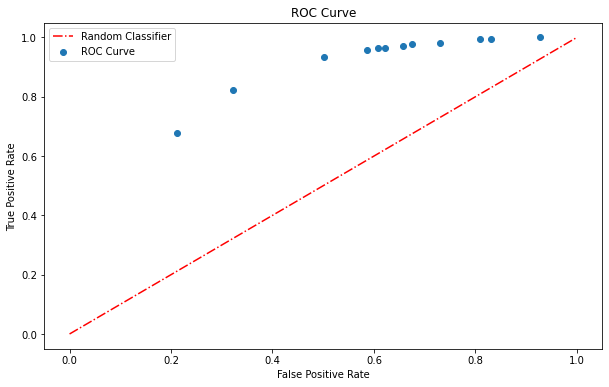

In [10]:
x = np.linspace(0,1,50)
y = x
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.scatter(FPR_sort, TPR_sort, label="ROC Curve")
ax.plot(x, y, 'r-.', label="Random Classifier")
ax.legend()
plt.show()

Every point that is above the red line (random classifier) in the ROC curve represent a better classifier than the random one, where the top left corner of the is a perfect classifier.

The 4th point from the right is the point we chose as the best classifier, its fot the confidence_val, realtive_size = 0.25, 0.4 threshold. 